# Project: It's Airborne

## Introduction

In this project, your task is to implement a Susceptible-Infected (SI) disease spreading model and run it on top of a temporal network, built from air transport data that contains departure and arrival times of flights. You'll study the dynamics of spreading and how the outcomes depend on where the process begins as well as the infectivity of the disease, and use static-network centrality measures to understand the roles that specific nodes play.

In addition to returning a short report of your results (including plots and visualizations), also return your commented Python code or notebook (all code related to the project as a single **zip** file). **Always label the axes in your figures!** When reporting your results, remember to answer all questions asked in the exercise sheet. Please note that this notebook contains only the programming tasks of the project, not the questions about interpreting the results. Therefore, before writing your report, consult the exercise sheet available in MyCourses.

## Model specifications

In the SI model, each node is either Susceptible (S) or Infected (I). When an Infected node is in contact with a Susceptible node, the Susceptible node may become infected with some probability $p \in [0, 1]$, reflecting the infectivity of the disease. Infected nodes remain Infected forever.

In our model that mimics the spread of disease through the air transport network, nodes are airports and time-stamped connections are flights between them. Initially, only one airport node (called the _seed_ node) is set to the Infected state, while all other airports are Susceptible. Now, following the SI process, a flight from an Infected source airport infects its Susceptible destination airport with probability $p \in [0, 1]$. Note that a flight can carry the infection only if its source airport is infected at the time of the flight’s departure! Infected airports remain infected for the rest of the simulation.

## Data description

The data that are used in the project are available at `/coursedata`. You can also download the data from the course MyCourses page as a `.zip` file. 

The flight data that you will use to perform your simulation are located in the file `events_US_air_traffic_GMT.txt`, where each row contains the following fields:

<pre>
1st column -> Source [0-278]
2nd column -> Destination [0-278]
3rd column -> Start Time (GMT) [seconds after Unix epoch time]
4th column -> End Time (GMT)
5th column -> Duration [Same as (EndTime-StartTime)]
</pre>

You can find the information about the airports in file `US_airport_id_info.csv`. `US_air_bg.png` is an image of the USA map used as a background image in some visualizations.

In [27]:
import networkx as nx
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy.stats
from PIL import Image

rng = np.random.default_rng()

# Data

Load the data from the correct folder and specify paths for files used in the project. If you run this notebook on your own computer, please specify the correct folder.

In [28]:
# Select data directory
import os
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    course_data_dir = '.'

event_file_path = os.path.join(course_data_dir ,'events_US_air_traffic_GMT.txt')
airport_info_file_path = os.path.join(course_data_dir ,'US_airport_id_info.csv')
background_image_file_path = os.path.join(course_data_dir , 'US_air_bg.png')

events = pd.read_csv(event_file_path, delimiter=' ')
airport_info = pd.read_csv(airport_info_file_path, delimiter=',', index_col=0)

print('The data directory is {path}'.format(path=course_data_dir))
print('The event file is at {path}'.format(path=event_file_path))
print('The airport info file is at {path}'.format(path=airport_info_file_path))
print('The visualization background image is at {path}'.format(path=background_image_file_path))

The data directory is /coursedata
The event file is at /coursedata/events_US_air_traffic_GMT.txt
The airport info file is at /coursedata/US_airport_id_info.csv
The visualization background image is at /coursedata/US_air_bg.png


## Visualization tools

The following visualization tools are provided to be used in the rest of the exercise. There is no need to modify these code blocks.

The function `plot_prevalence` is used in multiple tasks from Task 2 onwards and `plot_scatters_in_subplots` from Task 4 onwards. The function `plot_network_USA` is used in Task 6. 

As an extra visualization, you can find a function called `visualize_si` which animates the air transport using `matplotlib`. The animations use the background image `US_air_bg.png`, the airport id-info file `US_airport_id_info.csv` and the events file `events_US_air_traffic_GMT.txt`, all of which are available from the folder `/coursedata`. Note that this visualization is not needed for completion of the tasks, it’s for you to have some fun with!

In [29]:
def plot_prevalence(ax, prevalence_data, time_steps, colors, labels):
    """
    Plots the prevalence of the disease (proportion of infected
    nodes) as a function of time (before each time step).
    
    Parameters:
    -----------
    ax : plt.axes
        the axes on which to plot the prevalence
    prevalence_data : np.array or list
        the data to be plotted. Each row of prevalence_data is
        plotted as a separate plot. Number of columns should
        match the length of time_steps
    time_steps : np.array
        time steps used to calculate the prevalence. prevalence_data[N][i]
        should contain the proportion of nodes infected before time_steps[i]
        (in condition N)
    colors : list
        colors of the lines to be plotted. len(colors) should match the
        number of rows in prevalence_data
    labels : list
        labels of the lines to be plotted. len(labels) should match the
        number of rows in prevalence_data
        
    Returns:
    --------
    ax : plt.axes
        the axes on which the prevalence was plotted
    """
    time_steps = time_steps - time_steps[0] # origin shift: all times are now expressed as "after time_steps[0]"
    
    for prevalence, color, label in zip(prevalence_data, colors, labels):
        ax.plot(time_steps, prevalence, color = color, label = label)

    ax.legend(loc='lower right', fontsize='small')
    ax.set_xlabel("Time in seconds after first event")
    ax.grid()
    ax.set_ylabel("Prevalence of the disease")
    return ax

In [30]:
def plot_scatters_in_subplots(x_vals, y_vals, labels, n_columns=2, y_label='Infection time', x_labels=[]):
    """
    Creates a set of scatter plots, each of them located in
    a subplot of its own.
    
    Parameters:
    -----------
    x_vals : list
        x values of the scatter plots (e.g. values of network properties to be plotted); x_vals[i]
        should be a list of x values of type i for all nodes
    y_vals: iterable
        y values of the scatter plots (e.g. median infection times); y_vals will be
        separately plotted against all elements of x_vals
    labels : list
        labels of the scatter points to be plotted. len(labels) should match the
        number of elements in x_vals.
    n_columns : int
        how many columns should the final figure contain, i.e. how many
        subplots there should be at each row
    x_labels : list
        labels of the x axes for each subplot (given as strings); 
        if given, len(x_labels) should match the number of elements
        in x_vals.
    y_label : str
        label of the y axis
        
    Returns:
    --------
    fig : plt.figure
        The figure object containing the scatterplots
    """
    fig = plt.figure()
    
    n_subplots = len(x_vals)
    n_rows = int(np.ceil(n_subplots / n_columns))
    
    if len(x_labels) == 0:
        x_labels = labels
    
    for i, (x_val, label, x_label) in enumerate(zip(x_vals, labels, x_labels)):
        ax = fig.add_subplot(n_rows, n_columns, i + 1)
        ax.scatter(x_val, y_vals, label=label, alpha=0.2)
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
    fig.tight_layout()
    return fig

In [31]:
def plot_network_usa(ax, net, xycoords, background_image_file_path, edges=None, linewidths=None):
    """
    Plots the network on top of the USA map.
    This code makes use of the file US_air_bg.png available at /coursedata.
    If you want to use this function outside of Jupyterhub, the file
    should be located in the same directory where you run the code.

    Parameters
    ----------
    ax : plt.axes
        the axes on which to plot the network
    net : nx.Graph()
        the network to be plotted
    xycoords : dict
        dictionary of node_ids as keys and coordinates (x,y) as values,
        contains the coordinates of network nodes
    background_image_file_path: str
        path of the background image used in the visualization (string); 
        in this project, the path of US_air_bg.png
    edges : list 
        a list of node index tuples (node_i,node_j), the selection of 
        network edges to be plotted. Default None; in this case, all network edges are plotted.
    linewidths : list
        a list of widths of edges (for details, see nx.draw_networkx documentation)
        len(linewidths) should match len(edges) and linewidths should be given
        in the same order as edges. Default None, in this case, all edges
        are plotted with width one.
        
    Returns
    -------
    ax : plt.axes
        the axes on which the network is plotted
    """
    img = Image.open(background_image_file_path)
    axis_extent = (-6674391.856090588, 4922626.076444283,
                   -2028869.260519173, 4658558.416671531)
    ax.imshow(img, extent=axis_extent)
    ax.set_xlim((axis_extent[0], axis_extent[1]))
    ax.set_ylim((axis_extent[2], axis_extent[3]))
    ax.set_axis_off()
    nx.draw_networkx_nodes(net,
                     pos=xycoords,
                     node_color='k',
                     node_size=5,
                     alpha=0.2)
    if edges is None:
        edges = net.edges()
    
    if linewidths is None:
        linewidths = np.ones(len(edges))

    nx.draw_networkx_edges(
        net,
        pos=xycoords,
        edge_color='r',
        width=linewidths,
        edgelist=edges,
        alpha=linewidths)
    return ax

In [32]:
class SI_AnimHelper(object):
    """
    A class used for creating animated visualizations of the epidemic. 
    For a function making use of this class, see visualize_si below.
    
    Attributes
    ----------
    ed : np.array
        event data; each row corresponds to a flight and columns contain
        (in this order) the source, destination, start time, end time, and
        duration of each flight
    infection_times : numpy array
        infection times of the nodes (airports)
    xcoords : np.array
        x coordinates of network nodes (airports)
    ycoords : np.array
        y coordinates of network nodes (airports)
    fig : plt.figure
        a figure object for drawing the network
    ax : plt.axes
        a axes object for drawing the network
    axis_extend : set
        extend of the x and y axis
    img : matplotlib.image.AxesImage
        the image object containing the visualization
    time_text : matplotlib.text.Text
        the text object containing the text telling the current time point
    scat_planes : matplotlib.collections.PathCollection
        a scatter plot of the location of planes
    n : int
        the number of nodes (airports)
    airport_colors : np.array
        colors of nodes (airports)
    scat_airports : matplotlib.collections.PathCollection
        a scatter plot of the location of nodes (airports)
        
    Methods
    -------
    draw(frame_time)
        draws the situation of epidemic spreading at the given moment
        (that is, updates the attributes to correspond to the situation
        at the given moment)
    draw_anim(frame_time)
        calls draw and returns some of the updated attributes
    init()
        returns some attributes without updating
    """
    def __init__(self, infection_times, event_file_path, airport_info_file_path, background_image_file_path):
        """
        Parameters
        ----------
        infection_times : np.array
            infection times of nodes (airports)
        event_file_path : str
            path to the event information file
        airport_info_file_path : str
            path to the airport information file
        background_image_file_path: str
            path of the background image used in the visualization (string); 
            in this project, the path of US_air_bg.png
        """
        if not os.path.exists(event_file_path):
            raise IOError("File " + event_file_path + "could not be found")

        self.ed = np.genfromtxt(
            event_file_path,
            delimiter=' ',
            dtype=None,
            names=True,
            encoding=None
        )

        self.infection_times = infection_times

        if not os.path.exists(airport_info_file_path):
            raise IOError("File " + event_file_path + "could not be found")

        id_data = np.genfromtxt(
            airport_info_file_path,
            delimiter=',',
            dtype=None,
            names=True,
            encoding=None
        )
        self.xcoords = id_data['xcoordviz']
        self.ycoords = id_data['ycoordviz']
        self.fig = plt.figure(figsize=(10, 10))
        self.ax = self.fig.add_axes([0, 0, 1, 1])
        img = plt.imread(background_image_file_path)
        self.axis_extent = (-6674391.856090588, 4922626.076444283,
                            -2028869.260519173, 4658558.416671531)
        self.img = self.ax.imshow(img, extent=self.axis_extent)
        self.ax.set_xlim((self.axis_extent[0], self.axis_extent[1]))
        self.ax.set_ylim((self.axis_extent[2], self.axis_extent[3]))
        self.ax.set_axis_off()
        self.time_text = self.ax.text(
            0.1, 0.1, "", transform=self.ax.transAxes)
        self.scat_planes = self.ax.scatter([], [], s=0.2, color="k")

        self.n = len(self.xcoords)
        self.airport_colors = np.array(
            [[0, 1, 0] for i in range(self.n)], dtype=float)
        self.scat_airports = self.ax.scatter(
            self.xcoords, self.ycoords, c=self.airport_colors, s=5, alpha=0.2)

    def draw(self, frame_time):
        """
        Draws the current situation of the epidemic spreading.

        Parameters
        ----------
        frame_time : int
            the current time in seconds
            (should lie somewhere between 1229231100 and 1230128400)
        """
        time_str = time.asctime(time.gmtime(frame_time))
        self.time_text.set_text(time_str)
        # this should be improved
        unfinished_events = (self.ed['EndTime'] > frame_time)
        started_events = (self.ed['StartTime'] < frame_time)

        # oge = 'on going events'
        oge = self.ed[started_events * unfinished_events]
        fracs_passed = (float(frame_time) - oge['StartTime']) / oge['Duration']
        ongoing_xcoords = ((1 - fracs_passed) * self.xcoords[oge['Source']]
                           + fracs_passed * self.xcoords[oge['Destination']])
        ongoing_ycoords = ((1 - fracs_passed) * self.ycoords[oge['Source']]
                           + fracs_passed * self.ycoords[oge['Destination']])
        self.scat_planes.set_offsets(
            np.array([ongoing_xcoords, ongoing_ycoords]).T)
        self.event_durations = self.ed['Duration']

        infected = (self.infection_times < frame_time)

        self.airport_colors[infected] = (1, 0, 0)  # red
        self.airport_colors[~infected] = (0, 1, 1)  # green
        self.scat_airports = self.ax.scatter(
            self.xcoords, self.ycoords, c=self.airport_colors, s=20, alpha=0.5)

    def draw_anim(self, frame_time):
        """
        Draws the epidemic situation at a given time and returns some attributes.
        
        Parameters
        ----------
        frame_time : int
            the current time in seconds
            (should lie somewhere between 1229231100 and 1230128400)
            
        Returns
        -------
        time_text : matplotlib.text.Text
            the text object containing the text telling the current time point
        scat_planes : matplotlib.collections.PathCollection
            a scatter plot of the location of planes
        scat_airports : matplotlib.collections.PathCollection
            a scatter plot of the location of nodes (airports)
        """
        self.draw(frame_time)
        return self.time_text, self.scat_planes, self.scat_airports

    def init(self):
        """
        Returns some attributes without updating
        
        Parameters
        ----------
        None
        
        Returns
        -------
        time_text : matplotlib.text.Text
            the text object containing the text telling the current time point
        scat_planes : matplotlib.collections.PathCollection
            a scatter plot of the location of planes
        scat_airports : matplotlib.collections.PathCollection
            a scatter plot of the location of nodes (airports)
        """
        return self.time_text, self.scat_planes, self.scat_airports

In [33]:
def visualize_si(infection_times,
                 event_file_path,
                 airport_info_file_path,
                 background_image_file_path,
                 viz_start_time=1229231100,
                 viz_end_time=1230128400,
                 tot_viz_time_in_seconds=60,
                 fps=10,
                 save_fname=None,
                 writer='ffmpeg'):
    """
    Animates the infection process as a function of time. If you want to show the animation in a Jupyter notebook,
    add the line
    %matplotlib widget
    to your notebook before calling the function. Without this line, the animation can still be saved but is not
    shown.

    Parameters
    ----------
    infection_times : np array
        infection times of the nodes (airports)
    event_file_path : str
        path to the event information file
    airport_info_file_path : str
        path to the airport information file
    background_image_file_path: str
        path of the background image used in the visualization (string); 
        in this project, the path of US_air_bg.png
    viz_start_time : int
        start time in seconds after epoch. Default
        1229231100 corresponds to the beginning of the 
        simulation
    viz_end_time : int
        end_time in seconds after epoch. Default
        1230128400 corresponds to the end of the
        simulation
    tot_viz_time_in_seconds : int
        length of the animation for the viewer in seconds. 
        Default 60
    fps : int
        frames per second (use low values on slow computers).
        Default 10
    save_fname : str
        path to which to save the animation. Default None, in
        which case the animation is shown instead of saving.
    writer : str
        name of the matplitlib.animation Writer class for saving
        the animation. Default 'ffmpeg'
    """
    times = np.linspace(
        viz_start_time, viz_end_time, fps * tot_viz_time_in_seconds + 1)
    siah = SI_AnimHelper(infection_times, event_file_path, airport_info_file_path, background_image_file_path)
    ani = FuncAnimation(
        siah.fig, siah.draw_anim, init_func=siah.init, frames=times,
        interval=1000 / fps, blit=True
    ) # This is matplotlib.animation.FuncAnimation; see the Matplotlib documentation for details
    if save_fname is not None:
        print("Saving the animation can take quite a while.")

        print("Be patient...")

        ani.save(save_fname, writer=writer, codec='mpeg4')
    else:
        return ani

### Project Tasks Begin Here

### Task 1: Basic implementation

Implement the SI model using the temporal air traffic data in `events_US_air_traffic_GMT.txt`. Use the provided visualization module to check that your implementation works reasonably. Assume first that $p = 1$, i.e., the disease is always transmitted.

If Salt Lake City (SLC, node-id=27) is infected at the beginning of the data set, at which time
does Anchorage (ANC, node-id=41) become infected?

_Hint:_ The time point should fall within the range `1229283000-1229284000`.

In [34]:
def simulate_si(infection_prob, events, airport_info, rng, 
                seed=None, immunized_nodes=[], return_trans_nodes=True):
    """
    General function for simulating the SI dynamics.

    Parameters
    ----------
    infection_prob : float
        the probability of infection per flight
    events : pd.DataFrame
        flight data (source, destination, start time, end time, duration)
    airport_info : pd.DataFrame
        data about airport id's, symbols, names, and cities
    seed : int
        the seed node index. 
        Default None, in which case the seed node is selected randomly by rng
    rng : np.random.Generator
        random number generator. 
    immunized_nodes : list
        indexes of nodes that have been immunized (used in task 5).
        Default [], in which case no nodes are immunized
    return_trans_nodes : bool
        if True, the function returns for for each node i the 
        index of node j, from which the infection arrived to i. This
        parameter is used in task 6. Default False
        
    Returns:
    --------
    infection_times : iterable (list or np.array)
        time when each of the nodes gets infected, infection time of 
        non-infected nodes is Inf
    seed : int
        index of the seed node used
    trans_nodes : list or np.array
        the origin of infection (i.e. the source of the infection-carrying
        flight) for each node. For example, if node i gets infected by a 
        flight arriving from node j, trans_nodes[i] = j. For a node k that
        never gets infected, trans_nodes[k] = -1. This output is used in
        task 6. Only returned if return_trans_nodes == True
    
    """
    # Modify your implementation of simulate_si from task 1 to allow node immunization. To this end, add a list 
# (or set) of immunized nodes as an optional input, with an empty list (or set) as the default value. Then, 
# when about to infect a node, check if the node is in the list/set, and if, do not infect.


    ##filling np array with inf values
    infection_times = np.full(len(airport_info), np.inf)
    trans_nodes = np.full(len(airport_info), np.inf)
    ##changing events to np.array and sorting based on StartTime
    flights = np.array(events.to_records())
    sorted_flights = np.sort(flights, order='StartTime')
    ##setting infection time of seed node
    infection_times[seed] = sorted_flights[0]['StartTime']
    ##iterating through flights
    for flight in sorted_flights:
        source = flight['Source']
        destination = flight['Destination']
        arrival_time = flight['EndTime']
        departure_time = flight['StartTime']
        
        if infection_times[source] <= departure_time:
            if infection_times[destination] > arrival_time:
                if rng.random() <= infection_prob and destination not in immunized_nodes:
                    infection_times[destination] = arrival_time
                    trans_nodes[destination] = source
            
    
    #TODO: implement a function for running the SI simulation
    # Hints: 
    
    # Use infection_times to keep a record of the infection times of airports (it can be either a list
    # or an np.array). infection_times[i] should be the infection time of node i at all times. 
    
    # Initially, set the infection time of the seed node to the beginning of the simulation (that is,
    # the departure time of the first flight. Set the infection times of all other nodes to np.inf, 
    # indicating that they are not infected yet.
    
    # Whenever a node becomes infected, set its time of infection to the arrival time of the flight 
    # that infected it.
    
    # To implement the model, first sort all flights in increasing order of departure time, 
    # and then go through them in sequence. 
    # Is the source node infected at the departure time of the current flight 
    # (i.e. is infection_times[source] smaller than or equal to the departure time)? 
    # If so, check if the infection time of the target node is larger that the arrival time of the flight. 
    # If so, the flight infects the target node with probability p. In this case, 
    # set the target node's infection time to the flight's arrival time.
    # (Note: things are easier if you first set each node's infection time to be infinity (np.inf))
    
    # In most cases, looping directly through a pd.DataFrame object is a bad idea for computational 
    # efficiency. You can speed the computation up by first converting the DataFrame into 
    # a 2-dimensional np.array and then iterating over rows (each row corresponds to a flight). 
    
    # Note that this function is used in all tasks of the project. So, don't forget to invest 
    # enough time on implementing it carefully; this will pay back later!
    if return_trans_nodes:
        return infection_times, seed, trans_nodes
    return infection_times, seed

In [35]:
p = 1
id_seed = 27
id_target = 41

inf_times, seed, trans = simulate_si(p, events, airport_info, rng, seed=id_seed)

print( "Source node:\n", airport_info.loc[id_seed])

target_infection_time = int(inf_times[id_target])
print ("--------------------\n\n Target node: ")
print (airport_info.loc[id_target])
print ("infected at time {time!s}\n".format(time=target_infection_time))

Source node:
 symbol                          SLC
airport name    Salt Lake City Intl
city                 Salt Lake City
latitude                  40.788389
longitude               -111.977772
xcoordviz           -1121073.411983
ycoordviz              188655.57638
Name: 27, dtype: object
--------------------

 Target node: 
symbol                                 ANC
airport name    Ted Stevens Anchorage Intl
city                             Anchorage
latitude                         61.174361
longitude                      -149.996361
xcoordviz                  -2844925.506355
ycoordviz                   3257667.969141
Name: 41, dtype: object
infected at time 1229283600



### Task 2: Effect of infection probability $p$ on spreading speed

Run the SI model 30 times with each of the infection probabilities [0.01, 0.05, 0.1, 0.5, 1.0]. Again, let Salt Lake City (node-id=27) be the initially infected node. Record all infection times of the nodes. 

Plot the averaged prevalence $\rho(t)$ of the disease (fraction of infected nodes) as a function of time for each of the infection probabilities. Plot the 5 curves in one graph. You should be able to spot stepwise, nearly periodic plateaus in the curves.

In [10]:
def get_time_steps(events, n_time_steps):
    """
    Reads from the event file the flight departure and
    arrival times and divides the time from the first departure
    to the last arrival into n_time_steps steps. The first step
    should be the first departure time and the last step the
    last arrival time.
    
    Parameters:
    -----------
    events : pd.DataFrame
        flight data (source, destination, start time, end time, duration)
    n_time_steps : int
        number of time steps
        
    Returns:
    --------
    time_steps : np.array
        the time steps for calculating prevalence
    """
    # YOUR CODE HERE
    flights = np.array(events.to_records())
    sorted_flights = np.sort(flights, order='StartTime')
    sorted_endtime = np.sort(flights, order='EndTime')
    time_steps = np.linspace(sorted_flights[0]['StartTime'], sorted_endtime[-1]['EndTime'], n_time_steps)

    
    return time_steps

In [11]:
def calculate_prevalence(infection_times, time_steps):
    """
    Calculates the prevalence of the infection 
    (i.e. fraction of infected nodes) as a function
    of time. Prevalence is calculated using linear time steps,
    so that prevalence at each step is the fraction of nodes
    infected at the step, that is, nodes whose infection time
    is smaller than or equal to the step.
    
    Parameters:
    -----------
    infection_times : iterable (list or np.array)
        time when each node gets infected, infection time of 
        non-infected nodes is Inf
    time_steps : np.array
        the time steps for calculating prevalence
        
    Returns:
    --------
    prevalence : np.array
        prevalence (i.e. fraction of infected nodes) at each time step
    """
    prevalence = [] #REPLACE!
    n = 0
    # YOUR CODE HERE
    #TODO: write a function for calculating prevalence as a function of time
    # Hint: to get the prevalence, count the number of nodes infected at each time step and normalize by 
    # the total number of nodes
    for step in time_steps:
        for time in infection_times:
            if time <= step:
                n+=1
        prevalence.append(n/len(infection_times))
        n=0
    return np.array(prevalence)

<Axes: xlabel='Time in seconds after first event', ylabel='Prevalence of the disease'>

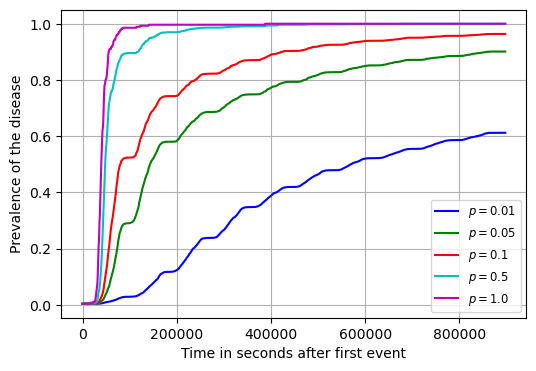

In [12]:
n_it = 30 # number of iterations
infection_probs = [0.01, 0.05, 0.1, 0.5, 1.0] # infection probabilities
id_seed = 27
n_time_steps = 1000

time_steps = get_time_steps(events, n_time_steps)
prevalence_data = [] # list or np.array. REPLACE!
# YOUR CODE HERE

#TODO: Calculate the prevalence for each infection probability
# Hints:

# Repeate simulate_si n_it times for each probability. At each iteration, calculate the prevalence. 
# After completing the iterations,average the prevalence over iterations.
for probability in infection_probs:
    prevalence_avg = []
    for iteration in range(0, n_it):
        inf_times, seed, trans = simulate_si(probability, events, airport_info, rng, seed=id_seed)
        prevalence = calculate_prevalence(inf_times, time_steps)
        prevalence_avg.append(prevalence)
    averaged_array = np.average(prevalence_avg, axis=0)
    prevalence_data.append(averaged_array)
    
# For calculating the prevalence, divide the whole time span (from the first departure time 
# to the last arrival) into equal-sized steps using the get_time_steps function you implemented above. 
# You want to use same time steps for all infection probabilities (these will define the x axis of 
# the visualization).

# For the prevalence calculations, use calculate_prevalence defined above. This function will be used 
# also in all later tasks, so don't worry about taking some time to implement it carefully.

# For the next step (visualization), you need an np.array (or a list of lists) called prevalence_data
# that contains the prevalence as a function of time for each infection probability.
# Each row of this array corresponds to an infection probability, and the number of columns should 
# equal to n_time_steps.

colors = ['b','g','r','c','m']
labels = ['$p = {{{}}}$'.format(p) for p in infection_probs]
fig, ax = plt.subplots(figsize=(6, 4))
plot_prevalence(ax, prevalence_data, time_steps, colors, labels)

In [13]:
# Save the figure in current directory
fig.savefig('effect_inf_prob.png', dpi=300)

## Task 3: Effect of seed node choice on spreading speed

Next, we will investigate how the choice of the initially infected seed node affects the spreading
speed. To this end, use nodes with node-ids [5, 38, 128, 139, 227] (DTW, SMF, CRW, DHN, GGG) as seeds
and $p = 0.1$, and run the simulation 30 times for each seed node. Then, plot the average
prevalence of the disease separately for each seed node as a function of time (recycling
your code for Task 2).

<Axes: xlabel='Time in seconds after first event', ylabel='Prevalence of the disease'>

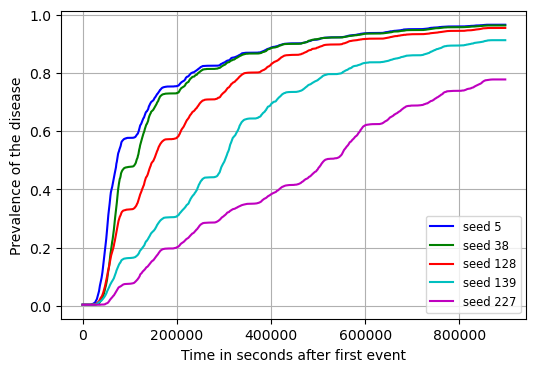

In [14]:
n_it = 30
p = 0.1
seed_nodes = [5, 38, 128, 139, 227]
n_time_steps = 1000

prevalence_data = []

time_steps = get_time_steps(events, n_time_steps)

# YOUR CODE HERE
#TODO: Calculate the prevalence for each seed node
#Hints: 
# You can re-use your code from task 2; just loop over seed nodes instead of infection probabilities.

# For the next step (visualization), you need a list (or np.array) called prevalence_data
# that contains the prevalence as a function of time (either list or np.array) for each seed node.
# Each row of this array corresponds to a seed node, and the number of columns should equal to
# n_time_steps.
for seeds in seed_nodes:
    prevalence_avg = []
    for iteration in range(0, n_it):
        inf_times, seed, trans = simulate_si(p, events, airport_info, rng, seed=seeds)
        prevalence = calculate_prevalence(inf_times, time_steps)
        prevalence_avg.append(prevalence)
    averaged_array = np.average(prevalence_avg, axis=0)
    prevalence_data.append(averaged_array)


prevalence_data = np.array(prevalence_data)

colors = ['b','g','r','c','m']
labels = ['seed ' + str(seed) for seed in seed_nodes]
fig, ax = plt.subplots(figsize=(6, 4))
plot_prevalence(ax, prevalence_data, time_steps, colors, labels)

In [15]:
# Save the figure in current directory
fig.savefig('effect_seed_node.png', dpi=300)

## Task 4: Where to hide?

Now, consider that you’d like to be as safe from the epidemic as possible. How should you select
your refuge? To answer this question, run your SI model 100 times with $p = 0.5$ using different
random nodes as seeds and record the median infection times for each node. Create scatter plots showing the median infection time of each node as a function of the following nodal network measures:

1. unweighted clustering coefficient $c$
2. degree $k$
3. strength $s$
4. unweighted betweenness centrality

Then, calculate the Spearman rank-correlation coefficient between each of the network measures and the median infection time to find out which of the measures is the best predictor for the infection times. Report the values of correlation coefficients.

To compute the above structural measures of the network, you first need a static network. Construct an aggregated, undirected, weighted network where the weight of each link corresponds to the number of flights between the nodes (in both directions). Then, compute the centrality measures for the aggregated network using ready-made NetworkX functions. Function `dict_to_vec` is given to make it easier to handle the network properties.

In [16]:
def construct_aggregated_network(events):
    """
    Constructs an aggregated, undirected, weighted network from flight data.
    Weight of an edge is the number of flights between the airports.
    
    Parameters:
    -----------
    events : pd.DataFrame
        flight data (source, destination, start time, end time, duration)
        
    Returns:
    --------
    net : nx.Graph()
        aggregated network
    """
    flights = np.array(events.to_records())
    undir_net = nx.Graph()
    for flight in flights:
        source = flight['Source']
        destination = flight['Destination']
        if undir_net.has_edge(source, destination):
            undir_net[source][destination]['weight'] += 1
        else:
            undir_net.add_edge(source, destination, weight = 1)
    
    return undir_net

In [17]:
def dict_to_vec(d):
    """
    Returns the values of a dictionary (e.g. a dictionary of network properties 
    returned by some networkX function) or a networkX DegreeView object
    as a list sorted in the order of dictionary keys (sorted with the sorted function). 
    Note that the order returned is not necessarily numerical; however, it is always the
    same for the same set of keys.
    
    Parameters:
    -----------
    d : dictionary or networkX DegreeView object
    
    Returns:
    --------
    vec : list
        list of d.values() sorted by d.keys()
    """
    vec = []
    if isinstance(d, dict):
        for key in sorted(d.keys()):
            vec.append(d[key])
    elif isinstance(d, nx.classes.reportviews.DegreeView):
        nodes = sorted([d1[0] for d1 in d])
        for node in nodes:
            vec.append(d[node])
    return vec

To check if the construction of the aggregated network is done correctly, check the number of flights between DTW (node-id=5) and LAX (node-id=16). The number of flights should be 90.

In [18]:
net = construct_aggregated_network(events)
airport1 = 5
airport2 = 16
print('The number of flights between airports {airport1} and {airport2} is {n_flights}.'.format(
    airport1=airport1, airport2=airport2, n_flights=net[airport1][airport2]['weight']))

The number of flights between airports 5 and 16 is 90.


Spearman r between median infection time and clustering: -0.132
Spearman r between median infection time and degree: -0.819
Spearman r between median infection time and strength: -0.89
Spearman r between median infection time and betweenness: -0.637


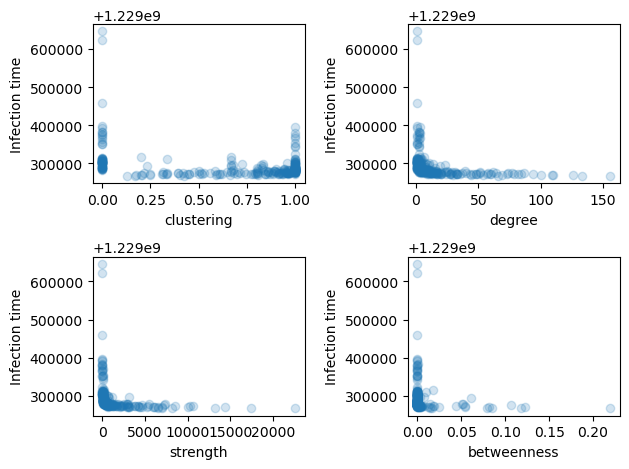

In [19]:
p = 0.5
n_seeds = 100

net = construct_aggregated_network(events)
inf_time_data = []
median_inf_times = []
props = []

random_seeds = rng.choice(278, n_seeds)

for iteration in range(0, n_seeds):
    inf_time, seed, trans = simulate_si(p, events, airport_info, rng, seed=random_seeds[iteration])
    inf_time_data.append(inf_time)


transposed_inf_time = [list(i) for i in zip(*inf_time_data)]
transposed_inf_time = np.array(transposed_inf_time)


for node_inf_time in transposed_inf_time:
    not_infinity_inf_times = []
    inf_count = 0 
    for time in node_inf_time:
        if time == np.inf:
            inf_count+=1
        else:
            not_infinity_inf_times.append(time)
    if inf_count > n_seeds/2:
        median_inf_times.append(np.inf)
    else:
        median_inf_times.append(np.median(not_infinity_inf_times))

median_inf_times = np.array(median_inf_times)
max_median = np.nanmax(median_inf_times[median_inf_times != np.inf])
median_inf_times = [max_median if x == np.inf else x for x in median_inf_times]

clustering_data = nx.clustering(net)
degree_data = {node:val for (node, val) in net.degree()}
strength_data = {node:val for (node, val) in net.degree(weight='weight')}
betweenness_data = nx.betweenness_centrality(net)


props.append(dict_to_vec(clustering_data))
props.append(dict_to_vec(degree_data))
props.append(dict_to_vec(strength_data))
props.append(dict_to_vec(betweenness_data))



#TODO: Run simulate_si for 100 random seeds to obtain the median infection time; obtain the listed 
# network properties
#Hints: 

# If a node gets infected in less than half of the iterations, its median infection time is Inf. 
# Before visualization and calculating the correlations, you need to replace these values with 
# some large number, e.g. the largest observed non-Inf median infection time.

# Feel free to use the networkX functions for obta ining the network properties. These functions return
# either dictionaries or networkX DegreeView objects; the dict_to_vec function given above
# transforms these into ordered lists.

# For the next step (visualization), you need a list (or n.array) of median infection times 
# (median_infection_times) and a nested list (called props) where each element is a list containing 
# the values of one network property for all nodes. All the lists in props need to be in the same
# order.

prop_names = ["clustering", "degree", "strength", "betweenness"]

fig = plot_scatters_in_subplots(props, median_inf_times, labels=prop_names)

rs = []

# YOUR CODE HERE
#TODO: calculate the Spearman rank correlation between each network property and median infection times 
#Hint: scipy.stats.spearmanr

rs.append(scipy.stats.spearmanr(median_inf_times,props[0]).statistic)
rs.append(scipy.stats.spearmanr(median_inf_times,props[1]).statistic)
rs.append(scipy.stats.spearmanr(median_inf_times,props[2]).statistic)
rs.append(scipy.stats.spearmanr(median_inf_times,props[3]).statistic)



for prop_name, r in zip(prop_names, rs):
    print('Spearman r between median infection time and {property}: {r:.3g}'.format(property=prop_name,r=r))

In [20]:
# Save the figure in current directory
fig.savefig('correlations_inf_time_and_node_attr.png', dpi=300)

## Task 5: Shutting down airports

Now take the role of a government official considering shutting down airports to prevent the
disease from spreading to the whole country. In our simulations, shutting down airports
corresponds to immunization: an airport that has been shut down can not become infected at
any point of the simulation and thus cannot transmit the disease.

One immunization strategy suggested for use in social networks is to pick a random node and immunize a random neighbour of this node. Your task is now to compare
this strategy against five other immunization strategies: the immunization of random nodes
and the immunization of with the largest values of the four node properties calculated in task 4. 

Using each of the immunization strategies, immunize 10 nodes. Then, plot the average prevalence as a function of time for each immunization strategy. Use $p=0.5$ and average the prevalence over 30 runs of the model for each immunization strategy, each with a different seed node (180 simulations in total). 

To reduce the variance due to the selection of seed nodes, use same seed nodes for investigating
all immunization strategies. To this end, first select your immunized nodes, and then select 30
random seed nodes such that none of them belongs to the group of immunized nodes in any of
the 6 different strategies.

Note that depending on your implementation of `simulate_si`, running this task may take some time (up to around 5 min). If the running time is particularly long, you may want to first use a lower value of `n_seeds` and set it to 30 only when you're sure that your code works as it should.

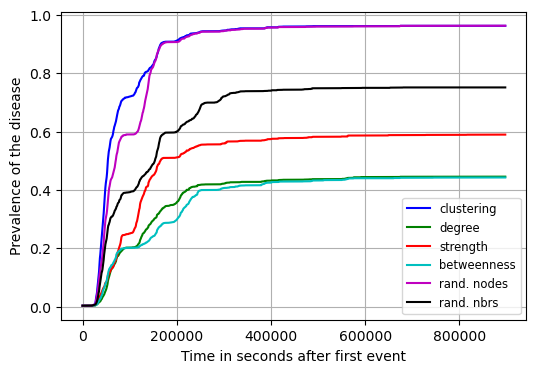

In [44]:
p = 0.5
n_seeds = 10
n_immunized = 10
n_time_steps = 1000

strategy_names = ["clustering", 
                  "degree", 
                  "strength", 
                  "betweenness", 
                  "rand. nodes",
                  "rand. nbrs"]
net = construct_aggregated_network(events)
clustering_immunized = sorted(clustering_data, key=clustering_data.get, reverse=True)[:n_immunized]
degree_immunized = sorted(degree_data, key=degree_data.get, reverse=True)[:n_immunized]
strength_immunized = sorted(strength_data, key=strength_data.get, reverse=True)[:n_immunized]
betweenness_immunized = sorted(betweenness_data, key=betweenness_data.get, reverse=True)[:n_immunized]
random_nodes = rng.choice(278, n_seeds)
rng_neighbors = []

while len(rng_neighbors) < n_immunized:
    random_node = rng.choice(278)
    random_neighbor_list = list(net.neighbors(random_node))
    random_neighbor = rng.choice(random_neighbor_list)
    if random_neighbor not in rng_neighbors:
        rng_neighbors.append(random_neighbor)
    

random_neighbors = rng.choice(list(rng_neighbors), n_immunized, replace=False)




simulation_seeds = rng.choice(
    [i for i in range(278) if i not in clustering_immunized 
     and i not in degree_immunized 
     and i not in strength_immunized 
     and i not in betweenness_immunized 
     and i not in random_nodes
     and i not in random_neighbors], 
    n_seeds, 
    replace=False
)

strategies = [clustering_immunized, degree_immunized, strength_immunized, betweenness_immunized, random_nodes, random_neighbors]


prevalence_data = []

time_steps = get_time_steps(events, n_time_steps)
strat_n = 0

for probability in strategy_names:
    prevalence_avg = []
    for iteration in range(0, n_seeds):
        inf_times, seed, trans = simulate_si(p, events, airport_info, rng, seed=simulation_seeds[iteration], immunized_nodes = strategies[strat_n])
        prevalence = calculate_prevalence(inf_times, time_steps)
        prevalence_avg.append(prevalence)
    averaged_array = np.average(prevalence_avg, axis=0)
    prevalence_data.append(averaged_array)
    strat_n += 1
    
# YOUR CODE HERE
#TODO: Calculate the prevalence for each immunization strategy
#Hints:

# Modify your implementation of simulate_si from task 1 to allow node immunization. To this end, add a list 
# (or set) of immunized nodes as an optional input, with an empty list (or set) as the default value. Then, 
# when about to infect a node, check if the node is in the list/set, and if, do not infect.

# Before running simulate_si, define the immunized nodes for each of the 6 strategies and the seed nodes. You want
# to use the same random seed nodes for each immunization strategy. While selecting the seeds, ensure that they
# are not among the immunized nodes.

# You can re-use your code from task 2, this time looping over immunization strategies.

# For the next step (visualization), you need a list (or np.array) called prevalence_data
# that contains the prevalence as a function of time (either list or np.array).
# Each row of this array corresponds to an immunization strategy, and the number of columns should equal to
# n_time_steps.

colors = ['b','g','r','c','m','k']
fig, ax = plt.subplots(figsize=(6, 4))
ax = plot_prevalence(ax, prevalence_data, time_steps, colors, labels=strategy_names)

In [45]:
# Save the figure in current directory
fig.savefig('immunization_strategies.png', dpi=300)

## Task 6: Disease-transmitting links

So far we have only analyzed the importance of network nodes — next, we will discuss the role of
links. We will do this by recording the number of times each link transmits the disease from one node to
another. 

So, adapt your code for recording the static links which are used to
transmit the disease. You can do this e.g. by storing for each node where the infection came from. For example, if node $i$ gets infected by a flight arriving from node $j$, you should store the information of $i$ being infected by $j$. This can be done by using a list `trans_nodes`, where `trans_nodes[i] = j`.

Run 50 simulations using random nodes as seeds and $p = 0.5$. For each simulation, record which links are used to infect the yet uninfected airports (either by first infection-carrying flights arriving to susceptible airports or by infecting flights arriving before the already recorded infection time). After running the simulations, compute the fraction of simulations where each link transmitted the disease ($f_{ij}$). For example, if the disease spread from node $a$ to node $b$ in 10 simulations out of 50, $f_{ab} = 0.2$.

Then, use the function `plot_network_USA` provided above to visualize the network on top of the US map. Adjust the width of the links according to the fractions $f_{ij}$ to better see the overall structure. Compare your visualization with the maximal spanning tree of the network.

Then, create scatter plots showing $f_{ij}$ as a function of the following link properties:

1. link weight $w_{ij}$
2. unweighted link betweenness centrality $eb_{ij}$ (`edge_betweenness_centrality` in NetworkX)

Also compute the Spearman correlation coefficients between $f_{ij}$ and the two link-wise
measures.

Spearman r between link transmission fraction and weight: 0.479
Spearman r between link transmission fraction and edge betweenness: 0.548


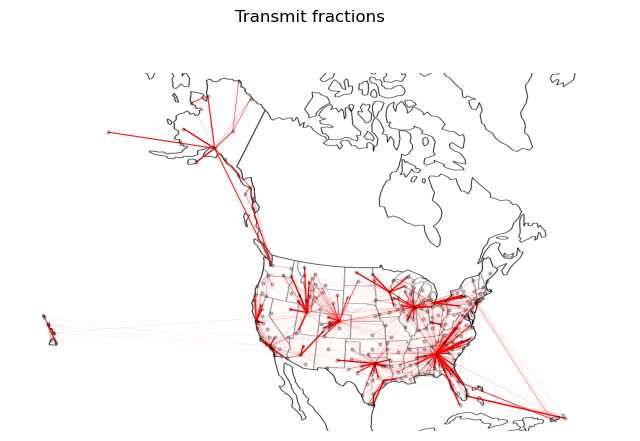

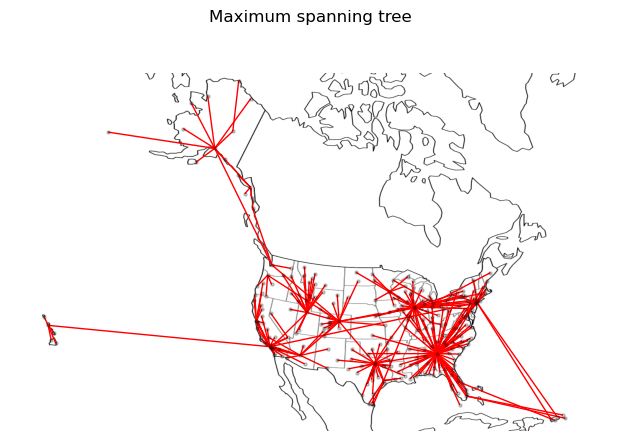

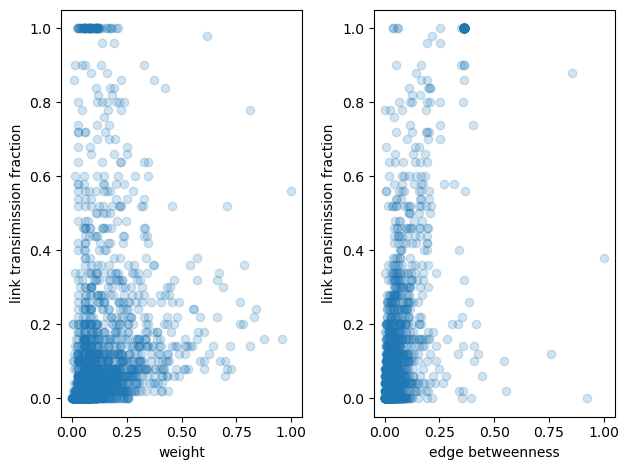

In [46]:
p = 0.5
n_seeds = 50

net = construct_aggregated_network(events)
links =  net.edges()
time_steps = get_time_steps(events, n_time_steps)
random_nodes = rng.choice(278, n_seeds)
trans_freq = np.zeros(len(links))
# YOUR CODE HERE
# TODO: Calculate the fraction of simulations each link carried the disease and 
# construct the maximal spanning tree of the network.

for iteration in range(0, n_seeds):
    inf_times, seed, trans_prob = simulate_si(p, events, airport_info, rng, seed=random_nodes[iteration])
    for i, j in enumerate(trans_prob):
        if not np.isinf(j):
            for link_index, link in enumerate(links):
                if i in set(link) and j in set(link):
                    trans_freq[link_index] +=1
    
mst = nx.maximum_spanning_tree(net)
link_trans_fracs = trans_freq/n_seeds

#Hints:

# Modify your implementation of simulate_si from task 1 to record which links carried the disease.

# For running the simulations, you can again re-use your code from task 2.

# When calculating the link transmission fractions, note that a link may have carried the disease 
# in different directions (i -> j and j -> i) in different simulations. 
# Since the transmission fraction is undirected, both directions count:
# f_ij = f_ji = (n_ij + n_ji) / n_simulations

# Feel free to use the networkX function for calculating the maximum spanning tree.

# For the next step (visualization), you need:
# - a list of links of the network (called `links`), 
# - a list of disease transmission fractions per link 
#   (called `link_trans_fracs`; this should be in the same order as `links`), and 
# - the maximum spanning tree (called `mst`).

# coordinates of nodes are needed for visualization
id_data = np.genfromtxt(airport_info_file_path, delimiter=',', dtype=None, names=True, encoding=None)
xycoords = {}
for row in id_data:
    xycoords[int(row['id'])] = (row['xcoordviz'], row['ycoordviz'])

fig_tf, ax_tf = plt.subplots(figsize=(8, 5))
plot_network_usa(ax_tf, net, xycoords, background_image_file_path, edges=links, 
                 linewidths=link_trans_fracs)
fig_tf.suptitle('Transmit fractions')

fig_mst, ax_mst = plt.subplots(figsize=(8, 5))
plot_network_usa(ax_mst, net, xycoords, background_image_file_path, edges=mst.edges())
fig_mst.suptitle('Maximum spanning tree')

# YOUR CODE HERE
#TODO: Obtain the weight and edge betweenness of each link.
#Hints: 

# Make use of nx.edge_betweenness_centrality.

# For the next step (visualization), you need lists or np.arrays of 
# - link weights (called `weights`) and 
# - edge betweenness centralities (called `ebs`).
weights_not_normalized = [d["weight"] for (u, v, d) in net.edges(data=True)]
weights = weights_not_normalized/np.max(weights_not_normalized)
                                                  
edge_betweenness = nx.edge_betweenness_centrality(net)
ebs = [edge_betweenness[(u, v)] for (u, v) in net.edges()]
ebs = ebs/np.max(ebs)

props = [weights, ebs]
prop_names = ['weight', 'edge betweenness']

fig_ltf = plot_scatters_in_subplots(props, link_trans_fracs, labels=prop_names, n_columns=2, \
                          y_label='link transimission fraction', x_labels=[])

rs = []
rs.append(scipy.stats.spearmanr(link_trans_fracs,props[0]).statistic)
rs.append(scipy.stats.spearmanr(link_trans_fracs,props[1]).statistic)
# YOUR CODE HERE
#TODO: Calculate the Spearman rank correlation between the link-wise properties and link transition fraction.

for prop_name, r in zip(prop_names, rs):
    print('Spearman r between link transmission fraction and {prop}: {r:.3g}'.format(prop=prop_name, r=r))


In [47]:
# Save the figures in current directory
fig_tf.savefig('transmitting_links_on_map.png', dpi=300)
fig_mst.savefig('maximum_spanning_tree_on_map.png', dpi=300)
fig_ltf.savefig('correlations_transmitting_links_and_link_attr.png', dpi=300)